# Topology (Persistent Homology) Detector on Tabular 

This notebook evaluates the repo’s **topology-based detector** (`detector_type='topology_score'`) on:

1. **Tabular data**: a real binary dataset (Breast Cancer Wisconsin).

For each dataset we:

- train a classifier (MLP),
- generate adversarial examples (FGSM/PGD),
- compute topology (persistent homology) features on local neighborhoods,
- fit a topology-score detector on validation scores,
- report detection metrics (AUROC/AUPRC/FPR@95%TPR).



In [1]:
# Imports + path setup + dependency checks
import os
import sys
import importlib
import numpy as np

import torch
import matplotlib.pyplot as plt

# Had some issues getting external dependencies to work thats why this is so compelx :) 
notebook_dir = os.path.dirname(os.path.abspath(''))
# If notebook is in notebooks/ subdirectory, go up one level to get project root
if os.path.basename(notebook_dir) == 'notebooks' or 'notebooks' in notebook_dir:
    current_dir = os.getcwd()
    if 'notebooks' in current_dir:
        # Split at notebooks and take the part before it
        project_root = os.path.abspath(os.path.join(current_dir.split('notebooks')[0].rstrip(os.sep), '.'))
    elif os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.abspath(os.path.join(current_dir, '..'))
    else:
        project_root = os.path.abspath(os.path.join(current_dir, '..'))
else:
    project_root = notebook_dir

if not os.path.exists(os.path.join(project_root, 'src')):
    # Try alternative: assume we're in project root already
    project_root = os.getcwd()
    if not os.path.exists(os.path.join(project_root, 'src')):
        # Last resort: go up from notebooks
        project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add project root to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Current working directory: {os.getcwd()}")
print(f"Project root: {project_root}")
print(f"src directory exists: {os.path.exists(os.path.join(project_root, 'src'))}")

# Public pipeline API
from src import api
from src.utils import ExperimentConfig, set_seed



Current working directory: c:\Users\shockers\Desktop\topology-and-robustness-in-DNNs\example_notebook
Project root: c:\Users\shockers\Desktop\topology-and-robustness-in-DNNs
src directory exists: True


In [2]:
# For the report we preferably have this toggle on!
from src.visualization import configure_mpl_style
configure_mpl_style(latex=False)

c:\Users\shockers\Desktop\topology-and-robustness-in-DNNs\src\visualization.py:101: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  - Use math mode when appropriate: r"$\alpha$" or r"$\mathrm{FPR}$"
c:\Users\shockers\Desktop\topology-and-robustness-in-DNNs\src\visualization.py:314: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  - math mode: r"$\mathrm{FPR}$"


In [3]:
# Helpers
from typing import Dict


def only_topo_keys(scores: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """Optional: keep only topo_* features (for visualization readability)."""
    return {k: v for k, v in scores.items() if str(k).startswith("topo_")}



In [4]:
# Experiment runner (topology detector) — reimplemented via the public pipeline API

def run_topology_detector_experiment(
    dataset_name: str,
    *,
    name: str,
    seed: int = 42,
    attack_type: str = "fgsm",
    epsilon: float = 0.1,
    max_points_for_scoring: int = 400,
):
    set_seed(seed)

    # Config
    cfg = ExperimentConfig(seed=seed, device="cpu")

    # Model training
    cfg.model.hidden_dims = [128, 64]
    cfg.model.epochs = 80
    cfg.model.learning_rate = 1e-3

    # Attack
    cfg.attack.attack_type = str(attack_type)
    cfg.attack.epsilon = float(epsilon)
    cfg.attack.num_steps = 30
    cfg.attack.step_size = float(epsilon) / 10.0
    cfg.attack.random_start = True

    # Topology neighborhoods computed in feature space
    cfg.graph.space = "feature"
    cfg.graph.use_topology = True
    cfg.graph.use_tangent = False  # we only need topology features here
    cfg.graph.topo_k = 40
    cfg.graph.topo_maxdim = 1
    cfg.graph.topo_min_persistence = 1e-6
    # Option 1: local PCA before PH (helps in high-d tabular/vector settings)
    cfg.graph.topo_preprocess = "pca"
    cfg.graph.topo_pca_dim = 10

    # Detector
    cfg.detector.detector_type = "topology_score"
    cfg.detector.topo_percentile = 95.0
    cfg.detector.topo_cov_shrinkage = 1e-3

    # Dataset
    bundle = api.get_dataset(dataset_name, cfg)

    # Model
    cfg.model.input_dim = int(bundle.X_train.shape[1])
    cfg.model.output_dim = int(bundle.meta.get("num_classes", 2))
    model = api.get_model(
        "MLP",
        cfg,
        input_dim=cfg.model.input_dim,
        output_dim=cfg.model.output_dim,
    )
    model = api.train(model, bundle, cfg, device=str(cfg.device), verbose=False, return_history=False)

    # Adversarial examples
    X_adv_val = api.generate_adversarial(model, bundle.X_val, bundle.y_val, cfg)
    X_adv_test = api.generate_adversarial(model, bundle.X_test, bundle.y_test, cfg)

    # Optional: evaluate only successful attacks (clean correct & adv incorrect)
    EVAL_ONLY_SUCCESSFUL_ATTACKS = True
    FILTER_CLEAN_TO_CORRECT = True

    clean_mask_val = np.ones(len(bundle.X_val), dtype=bool)
    clean_mask_test = np.ones(len(bundle.X_test), dtype=bool)
    if FILTER_CLEAN_TO_CORRECT:
        pred_val = api.predict(model, bundle.X_val, device=str(cfg.device), return_probs=False)
        pred_test = api.predict(model, bundle.X_test, device=str(cfg.device), return_probs=False)
        clean_mask_val = pred_val == np.asarray(bundle.y_val, dtype=int)
        clean_mask_test = pred_test == np.asarray(bundle.y_test, dtype=int)

    adv_mask_val = np.ones(len(X_adv_val), dtype=bool)
    adv_mask_test = np.ones(len(X_adv_test), dtype=bool)
    if EVAL_ONLY_SUCCESSFUL_ATTACKS:
        adv_mask_val = api.attack_success_mask(model, bundle.X_val, X_adv_val, bundle.y_val, device=str(cfg.device))
        adv_mask_test = api.attack_success_mask(model, bundle.X_test, X_adv_test, bundle.y_test, device=str(cfg.device))

    print(f"Val attack success: {adv_mask_val.sum()}/{len(adv_mask_val)} = {adv_mask_val.mean():.3f}")
    print(f"Test attack success: {adv_mask_test.sum()}/{len(adv_mask_test)} = {adv_mask_test.mean():.3f}")

    # Subsample scoring points (PH can be expensive)
    X_val_clean_used, _ = api.subsample_masked(bundle.X_val, bundle.y_val, clean_mask_val, max_points_for_scoring, seed=seed)
    X_test_clean_used, _ = api.subsample_masked(bundle.X_test, bundle.y_test, clean_mask_test, max_points_for_scoring, seed=seed + 1)
    X_val_adv_used, _ = api.subsample_masked(X_adv_val, bundle.y_val, adv_mask_val, max_points_for_scoring, seed=seed + 2)
    X_test_adv_used, _ = api.subsample_masked(X_adv_test, bundle.y_test, adv_mask_test, max_points_for_scoring, seed=seed + 3)

    # Scores (via API; uses bundle.X_train as reference)
    scores_val_clean = api.compute_scores(X_val_clean_used, model, bundle=bundle, cfg=cfg)
    scores_val_adv = api.compute_scores(X_val_adv_used, model, bundle=bundle, cfg=cfg)
    scores_test_clean = api.compute_scores(X_test_clean_used, model, bundle=bundle, cfg=cfg)
    scores_test_adv = api.compute_scores(X_test_adv_used, model, bundle=bundle, cfg=cfg)

    # Fit detector on validation
    scores_val_all = api.concat_scores(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate(
        [np.zeros(len(scores_val_clean[any_key]), dtype=int), np.ones(len(scores_val_adv[any_key]), dtype=int)]
    )
    detector = api.fit_detector(scores_val_all, labels_val, cfg)

    # Evaluate on test
    scores_test_all = api.concat_scores(scores_test_clean, scores_test_adv)
    any_key_t = next(iter(scores_test_all.keys()))
    labels_test = np.concatenate(
        [np.zeros(len(scores_test_clean[any_key_t]), dtype=int), np.ones(len(scores_test_adv[any_key_t]), dtype=int)]
    )

    raw_scores = np.asarray(detector.score(scores_test_all), dtype=float)
    metrics = api.evaluate_detection(labels_test, raw_scores)

    # A quick model accuracy readout (for parity with the original notebook)
    pred_test = api.predict(model, bundle.X_test, device=str(cfg.device), return_probs=False)
    test_acc = 100.0 * float(np.mean(pred_test == np.asarray(bundle.y_test, dtype=int)))

    print(f"\n=== {name} ===")
    print(f"Model test accuracy: {test_acc:.2f}%")
    print(f"Attack: {attack_type}  eps={epsilon}")
    print(f"Detection AUROC: {metrics['roc_auc']:.4f}  AUPRC: {metrics['pr_auc']:.4f}  FPR@95TPR: {metrics['fpr_at_tpr95']:.4f}")

    return {
        "name": name,
        "test_acc": float(test_acc),
        "attack": str(attack_type),
        "epsilon": float(epsilon),
        **{k: metrics[k] for k in ["roc_auc", "pr_auc", "fpr_at_tpr95"]},
    }



In [5]:
## 1) Tabular dataset: Breast Cancer Wisconsin

# (Now loaded via the public dataset registry)
_cfg_preview = ExperimentConfig(seed=42, device="cpu")
_bundle_preview = api.get_dataset("TABULAR", _cfg_preview)
X_all = np.concatenate([_bundle_preview.X_train, _bundle_preview.X_val, _bundle_preview.X_test], axis=0)
y_all = np.concatenate([_bundle_preview.y_train, _bundle_preview.y_val, _bundle_preview.y_test], axis=0)
print(f"Tabular dataset shape: X={X_all.shape}, y={y_all.shape}, positives={float(y_all.mean()):.3f}")

results = []
for attack_type, eps in [("fgsm", 0.10), ("pgd", 0.10)]:
    results.append(
        run_topology_detector_experiment(
            "TABULAR",
            name=f"BreastCancer ({attack_type}, eps={eps})",
            seed=42,
            attack_type=attack_type,
            epsilon=eps,
            max_points_for_scoring=250,
        )
    )

results


Tabular dataset shape: X=(569, 30), y=(569,), positives=0.627
Val attack success: 8/114 = 0.070
Test attack success: 14/114 = 0.123

=== BreastCancer (fgsm, eps=0.1) ===
Model test accuracy: 96.49%
Attack: fgsm  eps=0.1
Detection AUROC: 0.6740  AUPRC: 0.2022  FPR@95TPR: 0.7455
Val attack success: 9/114 = 0.079
Test attack success: 14/114 = 0.123

=== BreastCancer (pgd, eps=0.1) ===
Model test accuracy: 96.49%
Attack: pgd  eps=0.1
Detection AUROC: 0.6721  AUPRC: 0.2029  FPR@95TPR: 0.8182


[{'name': 'BreastCancer (fgsm, eps=0.1)',
  'test_acc': 96.49122807017544,
  'attack': 'fgsm',
  'epsilon': 0.1,
  'roc_auc': 0.674025974025974,
  'pr_auc': 0.20224265436356825,
  'fpr_at_tpr95': np.float64(0.7454545454545455)},
 {'name': 'BreastCancer (pgd, eps=0.1)',
  'test_acc': 96.49122807017544,
  'attack': 'pgd',
  'epsilon': 0.1,
  'roc_auc': 0.672077922077922,
  'pr_auc': 0.20289413733022754,
  'fpr_at_tpr95': np.float64(0.8181818181818182)}]

In [6]:
# Presentation-ready visualizations
#
# The cell below contains the original notebook plotting helpers.
# To verify the *public pipeline API* (`src/api.py`) has the same functionality,
# we also provide an API-based runner and use it in the final figure cell.

from dataclasses import dataclass
from typing import Any, Dict, Optional

from sklearn.decomposition import PCA

from src.data import DatasetBundle, split_and_scale, generate_synthetic_vector_classification
from src.visualization import plot_roc_from_metrics, plot_confusion_matrix as _plot_confusion_matrix


@dataclass
class TopoRunBundleAPI:
    name: str
    cfg: Any
    model: Any
    detector: Any

    X_test: np.ndarray
    X_adv_test: np.ndarray

    scores_test_all: Dict[str, np.ndarray]

    raw_scores_all: np.ndarray
    labels_all: np.ndarray
    metrics: Dict[str, Any]


def _bundle_from_xy(X: np.ndarray, y: np.ndarray, *, seed: int) -> DatasetBundle:
    X_train, y_train, X_val, y_val, X_test, y_test, scaler = split_and_scale(X, y, seed=seed)
    meta = {
        "input_kind": "vector",
        "clip": None,
        "num_classes": int(len(np.unique(y_train))),
        "scaler": scaler,
    }
    return DatasetBundle(
        np.asarray(X_train, dtype=np.float32), np.asarray(y_train, dtype=np.int64),
        np.asarray(X_val, dtype=np.float32), np.asarray(y_val, dtype=np.int64),
        np.asarray(X_test, dtype=np.float32), np.asarray(y_test, dtype=np.int64),
        meta=meta,
    )


def run_topology_detector_bundle_api(
    *,
    name: str,
    seed: int,
    attack_type: str,
    epsilon: float,
    n_for_scoring: int = 250,
    dataset_name: Optional[str] = None,
    X: Optional[np.ndarray] = None,
    y: Optional[np.ndarray] = None,
) -> TopoRunBundleAPI:
    """Train model + topology detector and return artifacts for plotting (API-based)."""
    set_seed(seed)

    cfg = ExperimentConfig(seed=seed, device="cpu")
    cfg.model.hidden_dims = [128, 64]
    cfg.model.epochs = 80
    cfg.model.learning_rate = 1e-3

    cfg.attack.attack_type = str(attack_type)
    cfg.attack.epsilon = float(epsilon)
    cfg.attack.num_steps = 30
    cfg.attack.step_size = float(epsilon) / 10.0
    cfg.attack.random_start = True

    cfg.graph.space = "feature"
    cfg.graph.use_topology = True
    cfg.graph.use_tangent = False
    cfg.graph.topo_k = 40
    cfg.graph.topo_maxdim = 1
    cfg.graph.topo_min_persistence = 1e-6
    cfg.graph.topo_preprocess = "pca"
    cfg.graph.topo_pca_dim = 3

    cfg.detector.detector_type = "topology_score"
    cfg.detector.topo_percentile = 95.0
    cfg.detector.topo_cov_shrinkage = 1e-3

    if dataset_name is not None:
        bundle = api.get_dataset(dataset_name, cfg)
    else:
        assert X is not None and y is not None
        bundle = _bundle_from_xy(np.asarray(X, dtype=float), np.asarray(y, dtype=int), seed=seed)

    cfg.model.input_dim = int(bundle.X_train.shape[1])
    cfg.model.output_dim = int(bundle.meta.get("num_classes", 2))
    model = api.get_model("MLP", cfg, input_dim=cfg.model.input_dim, output_dim=cfg.model.output_dim)
    model = api.train(model, bundle, cfg, device=str(cfg.device), verbose=False, return_history=False)

    X_adv_test = api.generate_adversarial(model, bundle.X_test, bundle.y_test, cfg)

    FILTER_CLEAN_TO_CORRECT = True
    EVAL_ONLY_SUCCESSFUL_ATTACKS = True

    clean_mask_test = np.ones(len(bundle.X_test), dtype=bool)
    if FILTER_CLEAN_TO_CORRECT:
        pred_test = api.predict(model, bundle.X_test, device=str(cfg.device), return_probs=False)
        clean_mask_test = pred_test == np.asarray(bundle.y_test, dtype=int)

    adv_mask_test = np.ones(len(X_adv_test), dtype=bool)
    if EVAL_ONLY_SUCCESSFUL_ATTACKS:
        adv_mask_test = api.attack_success_mask(model, bundle.X_test, X_adv_test, bundle.y_test, device=str(cfg.device))

    X_test_s, _ = api.subsample_masked(bundle.X_test, bundle.y_test, clean_mask_test, n_for_scoring, seed=seed + 1)
    X_adv_test_s, _ = api.subsample_masked(X_adv_test, bundle.y_test, adv_mask_test, n_for_scoring, seed=seed + 2)

    scores_test_clean = api.compute_scores(X_test_s, model, bundle=bundle, cfg=cfg)
    scores_test_adv = api.compute_scores(X_adv_test_s, model, bundle=bundle, cfg=cfg)
    scores_test_all = api.concat_scores(scores_test_clean, scores_test_adv)

    any_key_t = next(iter(scores_test_all.keys()))
    labels_all = np.concatenate(
        [np.zeros(len(scores_test_clean[any_key_t]), dtype=int), np.ones(len(scores_test_adv[any_key_t]), dtype=int)]
    )

    # Calibrate on validation (API helper)
    scores_val_clean = api.compute_scores(bundle.X_val, model, bundle=bundle, cfg=cfg)
    scores_val_adv = api.compute_scores(api.generate_adversarial(model, bundle.X_val, bundle.y_val, cfg), model, bundle=bundle, cfg=cfg)
    scores_val_all = api.concat_scores(scores_val_clean, scores_val_adv)
    any_key_v = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate(
        [np.zeros(len(scores_val_clean[any_key_v]), dtype=int), np.ones(len(scores_val_adv[any_key_v]), dtype=int)]
    )

    detector = api.fit_detector(scores_val_all, labels_val, cfg)

    raw_scores_all = np.asarray(detector.score(scores_test_all), dtype=float)
    metrics = api.evaluate_detection(labels_all, raw_scores_all)

    return TopoRunBundleAPI(
        name=name,
        cfg=cfg,
        model=model,
        detector=detector,
        X_test=X_test_s,
        X_adv_test=X_adv_test_s,
        scores_test_all=scores_test_all,
        raw_scores_all=raw_scores_all,
        labels_all=labels_all,
        metrics=metrics,
    )


def plot_score_hist_api(bundle: TopoRunBundleAPI, *, bins: int = 40):
    raw_scores_clean = bundle.raw_scores_all[: len(bundle.X_test)]
    raw_scores_adv = bundle.raw_scores_all[len(bundle.X_test):]

    plt.figure(figsize=(7, 4))
    plt.hist(raw_scores_clean, bins=bins, alpha=0.6, density=True, label="clean")
    plt.hist(raw_scores_adv, bins=bins, alpha=0.6, density=True, label="adversarial")
    thr = float(getattr(bundle.detector, "threshold", np.nan))
    if np.isfinite(thr):
        plt.axvline(thr, color="k", linestyle="--", linewidth=1, label=f"threshold={thr:.3f}")
    plt.title(f"{bundle.name}: topology score distribution")
    plt.xlabel("topology_mahalanobis score")
    plt.ylabel("density")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_roc_curve_api(bundle: TopoRunBundleAPI):
    plot_roc_from_metrics(bundle.metrics, title=f"{bundle.name}: ROC")


def plot_confusion_matrix_api(bundle: TopoRunBundleAPI):
    thr = float(getattr(bundle.detector, "threshold", 0.0))
    _plot_confusion_matrix(
        bundle.labels_all,
        y_scores=bundle.raw_scores_all,
        threshold=thr,
        labels=("clean", "adv"),
    )


def plot_pca_inputs_api(bundle: TopoRunBundleAPI):
    X_all = np.vstack([bundle.X_test, bundle.X_adv_test])
    status = np.array([0] * len(bundle.X_test) + [1] * len(bundle.X_adv_test))
    thr = float(getattr(bundle.detector, "threshold", 0.0))
    flagged = bundle.raw_scores_all > thr

    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X_all)

    plt.figure(figsize=(7, 5))
    plt.scatter(X2[(status == 0) & (~flagged), 0], X2[(status == 0) & (~flagged), 1], s=14, alpha=0.5, label="clean (not flagged)")
    plt.scatter(X2[(status == 0) & (flagged), 0], X2[(status == 0) & (flagged), 1], s=18, alpha=0.9, label="clean (flagged)", marker="x")
    plt.scatter(X2[(status == 1) & (~flagged), 0], X2[(status == 1) & (~flagged), 1], s=14, alpha=0.5, label="adv (not flagged)")
    plt.scatter(X2[(status == 1) & (flagged), 0], X2[(status == 1) & (flagged), 1], s=18, alpha=0.9, label="adv (flagged)", marker="x")

    plt.title(f"{bundle.name}: PCA of input space (scaled)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_pca_topology_features_api(bundle: TopoRunBundleAPI):
    keys = sorted(bundle.scores_test_all.keys())
    V = np.column_stack([bundle.scores_test_all[k] for k in keys]).astype(float)

    thr = float(getattr(bundle.detector, "threshold", 0.0))
    flagged = bundle.raw_scores_all > thr
    status = bundle.labels_all.astype(int)

    pca = PCA(n_components=2, random_state=0)
    V2 = pca.fit_transform(V)

    plt.figure(figsize=(7, 5))
    plt.scatter(V2[(status == 0) & (~flagged), 0], V2[(status == 0) & (~flagged), 1], s=14, alpha=0.5, label="clean (not flagged)")
    plt.scatter(V2[(status == 0) & (flagged), 0], V2[(status == 0) & (flagged), 1], s=18, alpha=0.9, label="clean (flagged)", marker="x")
    plt.scatter(V2[(status == 1) & (~flagged), 0], V2[(status == 1) & (~flagged), 1], s=14, alpha=0.5, label="adv (not flagged)")
    plt.scatter(V2[(status == 1) & (flagged), 0], V2[(status == 1) & (flagged), 1], s=18, alpha=0.9, label="adv (flagged)", marker="x")

    plt.title(f"{bundle.name}: PCA of topology feature space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Original notebook helpers follow (kept for reference) ---
from dataclasses import dataclass
from typing import Any, List

from sklearn.decomposition import PCA


def _scores_to_matrix(scores: Dict[str, np.ndarray], keys: List[str]) -> np.ndarray:
    return np.column_stack([scores[k] for k in keys]).astype(float)


@dataclass
class TopoRunBundle:
    name: str
    config: Any
    model: Any
    detector: Any

    X_test: np.ndarray
    y_test: np.ndarray
    X_adv_test: np.ndarray

    scores_test_clean: Dict[str, np.ndarray]
    scores_test_adv: Dict[str, np.ndarray]
    scores_test_all: Dict[str, np.ndarray]

    raw_scores_clean: np.ndarray
    raw_scores_adv: np.ndarray
    raw_scores_all: np.ndarray
    labels_all: np.ndarray
    metrics: Dict[str, Any]


def run_topology_detector_bundle(
    X,
    y,
    *,
    name: str,
    seed: int,
    attack_type: str,
    epsilon: float,
    n_for_scoring: int = 250,
) -> TopoRunBundle:
    """Train model + topology detector and return artifacts for plotting."""
    set_seed(seed)

    X_train, y_train, X_val, y_val, X_test, y_test, _ = split_and_scale(X, y, seed=seed)
    X_train = np.asarray(X_train, dtype=float); y_train = np.asarray(y_train, dtype=int)
    X_val = np.asarray(X_val, dtype=float); y_val = np.asarray(y_val, dtype=int)
    X_test = np.asarray(X_test, dtype=float); y_test = np.asarray(y_test, dtype=int)

    config = ExperimentConfig(seed=seed, device='cpu')
    config.model.input_dim = int(X_train.shape[1])
    config.model.hidden_dims = [128, 64]
    config.model.epochs = 80
    config.model.learning_rate = 1e-3

    config.attack.attack_type = str(attack_type)
    config.attack.epsilon = float(epsilon)
    config.attack.num_steps = 30
    config.attack.step_size = float(epsilon) / 10.0
    config.attack.random_start = True

    config.graph.space = 'feature'
    config.graph.use_topology = True
    config.graph.use_tangent = False
    config.graph.topo_k = 40
    config.graph.topo_maxdim = 1
    config.graph.topo_min_persistence = 1e-6
    # Option 1: local PCA before PH (helps in high-d tabular/vector settings)
    config.graph.topo_preprocess = 'pca'
    config.graph.topo_pca_dim = 3

    config.detector.detector_type = 'topology_score'
    config.detector.topo_percentile = 95.0
    config.detector.topo_cov_shrinkage = 1e-3

    train_loader, val_loader, test_loader = create_data_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=config.model.batch_size
    )

    model = TwoMoonsMLP(
        input_dim=config.model.input_dim,
        hidden_dims=config.model.hidden_dims,
        output_dim=2,
        activation=config.model.activation,
    )

    train_model(model, train_loader, val_loader, config.model, device=config.device, verbose=False)

    # Reference feature-space set
    Z_train = extract_features_batch(model, X_train, layer='penultimate', device=config.device)
    logits_train = get_model_logits(model, X_train, device=config.device)
    probs_train = torch.softmax(torch.as_tensor(logits_train, dtype=torch.float32), dim=1).cpu().numpy()
    f_train = probs_train[:, 1]

    # Adversarial examples
    X_adv_val = generate_adversarial_examples(model, X_val, y_val, config.attack, device=config.device)
    X_adv_test = generate_adversarial_examples(model, X_test, y_test, config.attack, device=config.device)

    # Subsample consistently (same indices for clean+adv)
    rng = np.random.default_rng(seed)
    n_test = len(X_test)
    n = int(min(n_for_scoring, n_test))
    idx_test = rng.choice(n_test, size=n, replace=False)

    X_test_s = X_test[idx_test]
    y_test_s = y_test[idx_test]
    X_adv_test_s = X_adv_test[idx_test]

    # Filter to SUCCESSFUL attacks only (clean correct AND adv wrong)
    pred_test_clean = get_model_predictions(model, X_test_s, device=config.device)
    pred_test_adv = get_model_predictions(model, X_adv_test_s, device=config.device)
    clean_correct_test = (pred_test_clean == y_test_s)
    success_test = clean_correct_test & (pred_test_adv != y_test_s)

    # Keep only clean-correct + successful-adv for plotting
    X_test_s = X_test_s[clean_correct_test]
    y_test_s = y_test_s[clean_correct_test]
    X_adv_test_s = X_adv_test_s[success_test]

    print(f"[viz] Test success: {success_test.sum()}/{len(success_test)} = {success_test.mean():.3f}")

    n_val = len(X_val)
    n2 = int(min(n_for_scoring, n_val))
    idx_val = rng.choice(n_val, size=n2, replace=False)

    X_val_s = X_val[idx_val]
    y_val_s = y_val[idx_val]
    X_adv_val_s = X_adv_val[idx_val]

    pred_val_clean = get_model_predictions(model, X_val_s, device=config.device)
    pred_val_adv = get_model_predictions(model, X_adv_val_s, device=config.device)
    clean_correct_val = (pred_val_clean == y_val_s)
    success_val = clean_correct_val & (pred_val_adv != y_val_s)

    X_val_s = X_val_s[clean_correct_val]
    y_val_s = y_val_s[clean_correct_val]
    X_adv_val_s = X_adv_val_s[success_val]

    print(f"[viz] Val success: {success_val.sum()}/{len(success_val)} = {success_val.mean():.3f}")

    # Topology features
    scores_val_clean = compute_topology_feature_scores(
        X_val_s, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_val_adv = compute_topology_feature_scores(
        X_adv_val_s, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_test_clean = compute_topology_feature_scores(
        X_test_s, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_test_adv = compute_topology_feature_scores(
        X_adv_test_s, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )

    # Fit detector on val
    scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[any_key]), dtype=int),
        np.ones(len(scores_val_adv[any_key]), dtype=int),
    ])
    detector = train_graph_detector(scores_val_all, labels_val, config.detector)

    # Evaluate on test
    scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
    labels_all = np.concatenate([
        np.zeros(len(next(iter(scores_test_clean.values()))), dtype=int),
        np.ones(len(next(iter(scores_test_adv.values()))), dtype=int),
    ])

    score_fn = getattr(detector, 'score', None)
    assert callable(score_fn)
    raw_scores_all = np.asarray(score_fn(scores_test_all), dtype=float)
    raw_scores_clean = raw_scores_all[: len(X_test_s)]
    raw_scores_adv = raw_scores_all[len(X_test_s):]

    metrics = evaluate_detector(labels_all, raw_scores_all)

    return TopoRunBundle(
        name=name,
        config=config,
        model=model,
        detector=detector,
        X_test=X_test_s,
        y_test=y_test_s,
        X_adv_test=X_adv_test_s,
        scores_test_clean=scores_test_clean,
        scores_test_adv=scores_test_adv,
        scores_test_all=scores_test_all,
        raw_scores_clean=raw_scores_clean,
        raw_scores_adv=raw_scores_adv,
        raw_scores_all=raw_scores_all,
        labels_all=labels_all,
        metrics=metrics,
    )


def plot_score_hist(bundle: TopoRunBundle, *, bins: int = 40):
    plt.figure(figsize=(7, 4))
    plt.hist(bundle.raw_scores_clean, bins=bins, alpha=0.6, density=True, label='clean')
    plt.hist(bundle.raw_scores_adv, bins=bins, alpha=0.6, density=True, label='adversarial')
    thr = float(getattr(bundle.detector, 'threshold', np.nan))
    if np.isfinite(thr):
        plt.axvline(thr, color='k', linestyle='--', linewidth=1, label=f'threshold={thr:.3f}')
    plt.title(f"{bundle.name}: topology score distribution")
    plt.xlabel('topology_mahalanobis score')
    plt.ylabel('density')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_roc_curve(bundle: TopoRunBundle):
    """ROC plot using shared implementation in src.visualization."""
    from src.visualization import plot_roc_from_metrics

    plot_roc_from_metrics(
        bundle.metrics,
        title=f"{bundle.name}: ROC",
    )


def plot_confusion_matrix(bundle: TopoRunBundle):
    """Confusion plot using shared implementation in src.visualization."""
    from src.visualization import plot_confusion_matrix as _plot_confusion_matrix

    thr = float(getattr(bundle.detector, 'threshold', 0.0))
    _plot_confusion_matrix(
        bundle.labels_all,
        y_scores=bundle.raw_scores_all,
        threshold=thr,
        labels=("clean", "adv"),
    )


def plot_pca_inputs(bundle: TopoRunBundle):
    X_all = np.vstack([bundle.X_test, bundle.X_adv_test])
    status = np.array([0] * len(bundle.X_test) + [1] * len(bundle.X_adv_test))  # 0 clean, 1 adv
    thr = float(getattr(bundle.detector, 'threshold', 0.0))
    flagged = (bundle.raw_scores_all > thr)

    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X_all)

    plt.figure(figsize=(7, 5))
    plt.scatter(X2[(status == 0) & (~flagged), 0], X2[(status == 0) & (~flagged), 1], s=14, alpha=0.5, label='clean (not flagged)')
    plt.scatter(X2[(status == 0) & (flagged), 0], X2[(status == 0) & (flagged), 1], s=18, alpha=0.9, label='clean (flagged)', marker='x')
    plt.scatter(X2[(status == 1) & (~flagged), 0], X2[(status == 1) & (~flagged), 1], s=14, alpha=0.5, label='adv (not flagged)')
    plt.scatter(X2[(status == 1) & (flagged), 0], X2[(status == 1) & (flagged), 1], s=18, alpha=0.9, label='adv (flagged)', marker='x')

    plt.title(f"{bundle.name}: PCA of input space (scaled)")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_pca_topology_features(bundle: TopoRunBundle):
    keys = sorted(bundle.scores_test_all.keys())
    V = _scores_to_matrix(bundle.scores_test_all, keys)

    thr = float(getattr(bundle.detector, 'threshold', 0.0))
    flagged = (bundle.raw_scores_all > thr)
    status = bundle.labels_all.astype(int)

    pca = PCA(n_components=2, random_state=0)
    V2 = pca.fit_transform(V)

    plt.figure(figsize=(7, 5))
    plt.scatter(V2[(status == 0) & (~flagged), 0], V2[(status == 0) & (~flagged), 1], s=14, alpha=0.5, label='clean (not flagged)')
    plt.scatter(V2[(status == 0) & (flagged), 0], V2[(status == 0) & (flagged), 1], s=18, alpha=0.9, label='clean (flagged)', marker='x')
    plt.scatter(V2[(status == 1) & (~flagged), 0], V2[(status == 1) & (~flagged), 1], s=14, alpha=0.5, label='adv (not flagged)')
    plt.scatter(V2[(status == 1) & (flagged), 0], V2[(status == 1) & (flagged), 1], s=18, alpha=0.9, label='adv (flagged)', marker='x')

    plt.title(f"{bundle.name}: PCA of topology feature space")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



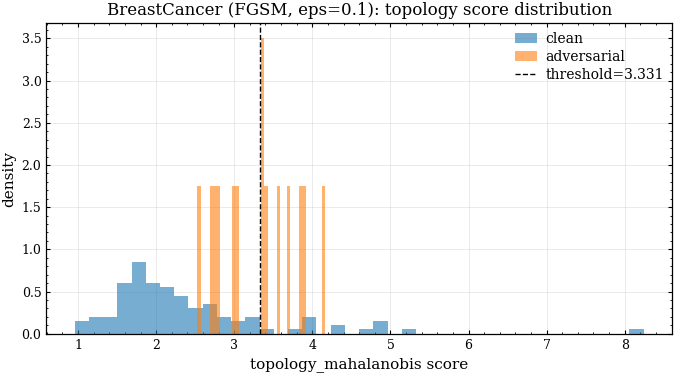

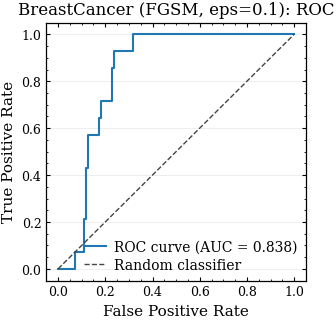

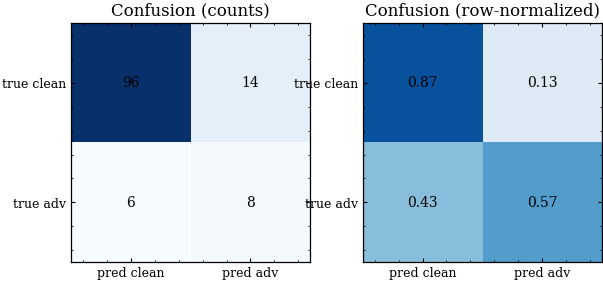

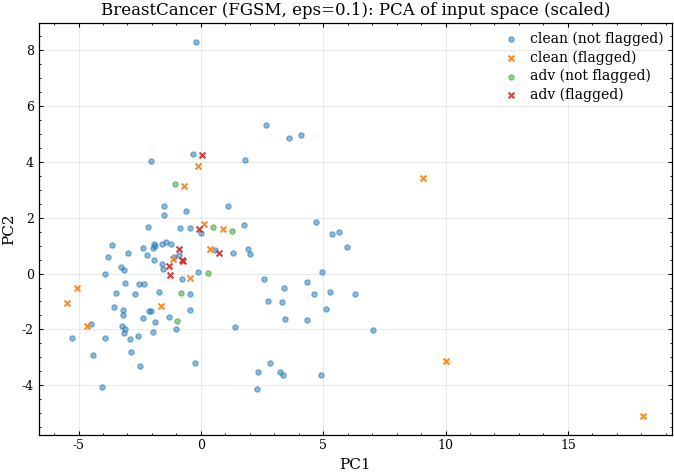

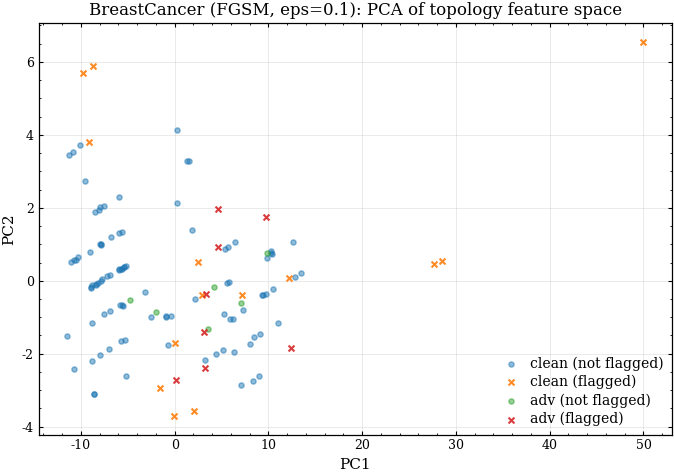

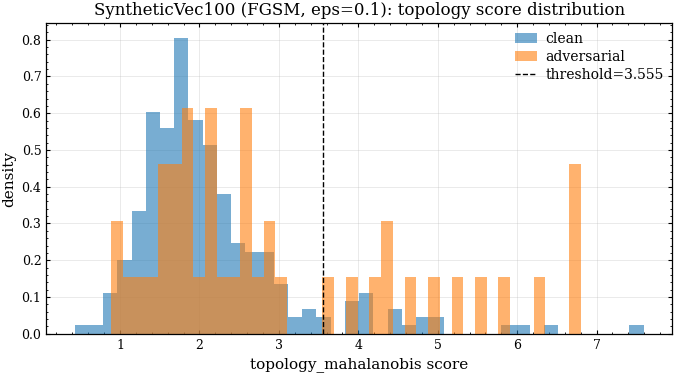

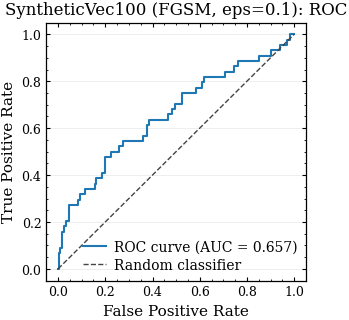

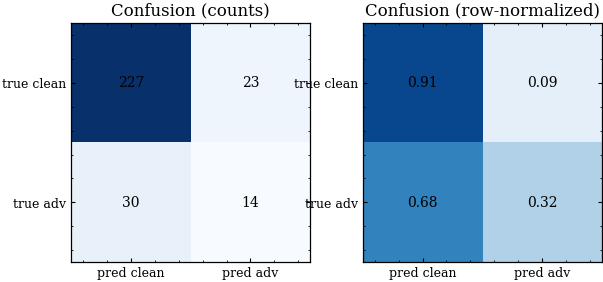

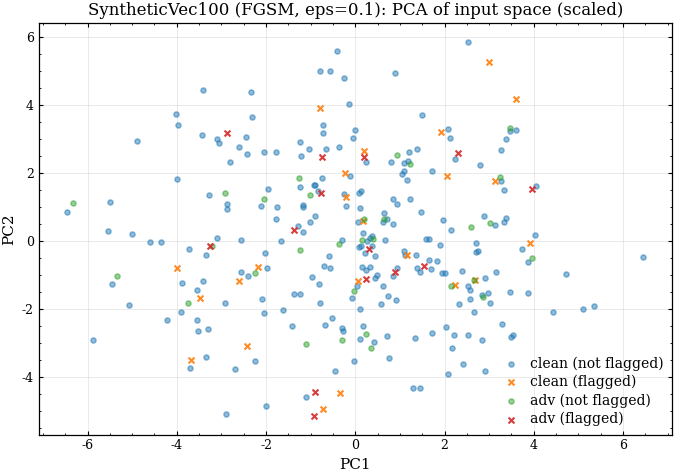

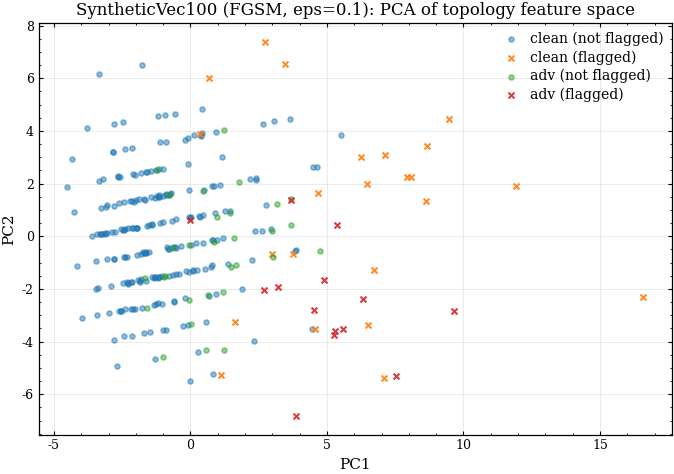

In [7]:
# Generate figures (pick one representative run per dataset for slides)

# Tabular (Breast Cancer) – FGSM (dataset registry)
bundle_bc = run_topology_detector_bundle_api(
    dataset_name="TABULAR",
    name="BreastCancer (FGSM, eps=0.1)",
    seed=42,
    attack_type="fgsm",
    epsilon=0.1,
    n_for_scoring=200,
)

plot_score_hist_api(bundle_bc)
plot_roc_curve_api(bundle_bc)
plot_confusion_matrix_api(bundle_bc)
plot_pca_inputs_api(bundle_bc)
plot_pca_topology_features_api(bundle_bc)

# Vector (Synthetic 100D) – FGSM (not in registry; generated here)
X_vec, y_vec = generate_synthetic_vector_classification(n_samples=2000, n_features=100, random_state=7)

bundle_vec = run_topology_detector_bundle_api(
    X=X_vec,
    y=y_vec,
    name="SyntheticVec100 (FGSM, eps=0.1)",
    seed=7,
    attack_type="fgsm",
    epsilon=0.1,
    n_for_scoring=250,
)

plot_score_hist_api(bundle_vec)
plot_roc_curve_api(bundle_vec)
plot_confusion_matrix_api(bundle_vec)
plot_pca_inputs_api(bundle_vec)
plot_pca_topology_features_api(bundle_vec)

